# 使用baostock数据进行股票收益分析

In [171]:
import baostock as bs
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import multiprocessing

In [191]:
#### 登陆系统 ####
lg = bs.login()

login success!


## 定义一个获取股票数据的class

In [118]:
class Stock(object):
    '''
    get a stock info,including open high low close preclose pctchange...
    
    Parameters
    ------
    code :"sh.600000"
    start_date: '2017-06-01'
    end_date: '2017-12-31'
    frequency: "d"
    adjustflag: "3"
    
    Returns
    ------
    Pandas DataFrame
    
    Examples
    ------
    >>> stock_600000 = get_stock_info(code = "sh.600000",start_date = '2017-06-01',end_date = '2017-12-31',frequency = 'd',adjustflag = '3')
    '''
  
    def __init__(self,code,start_date,end_date,frequency = 'd',adjustflag='3'):
        self.__code = code
        self.__start_date = start_date
        self.__end_date = end_date
        self.__frequency = frequency
        self.__adjustflag = adjustflag

    #### 获取历史K线数据 ####
    def get_stock_info(self):
        rs = bs.query_history_k_data_plus(self.__code,
            "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST",
            start_date=self.__start_date, end_date=self.__end_date, 
            frequency=self.__frequency, adjustflag=self.__adjustflag) #frequency="d"取日k线，adjustflag="3"默认不复权

        # 输出为dataframe
        #### 打印结果集 ####
        data_list = []
        while (rs.error_code == '0') & rs.next():
            # 获取一条记录，将记录合并在一起
            data_list.append(rs.get_row_data())
        result = pd.DataFrame(data_list, columns=rs.fields)

        # 修改字段类型
        result['date'] = pd.to_datetime(result['date'])
        result['pctChg'] = result['pctChg'].astype('float')
        result['close'] = result['close'].astype('float')
        result['open'] = result['open'].astype('float')
        result['high'] = result['high'].astype('float')
        result['low'] = result['low'].astype('float')
        result.sort_values(by='date',ascending=False,inplace=True)
        return result
    
    # plot 股票曲线
    def plot_curve(self,plot_type):
        result = self.get_stock_info()
        dt = result['date']
        if plot_type in ['return_ratio','close_price']:
            pass
        else:
            raise ValueError('Not a right plot type')
        if plot_type == 'return_ratio':
            data = result['pctChg']
        elif plot_type == 'close_price':
            data = result['close']
        plt.plot(dt,data)
    
    # 获取一些指标
    def get_statistics(self,print_info=True):
        result = self.get_stock_info()

        # 区间开盘价、最高收盘价、最低收盘价、收盘价
        peroid_open_price = result['open'].iloc[-1]
        period_max_price = max(result['close'])
        period_min_price = min(result['close'])
        period_close_price = result['close'].iloc[0]
        
        # 区间最高收益率、最大回撤、区间收益率
        period_return_ratio = period_close_price/peroid_open_price - 1
        period_max_return = period_max_price/peroid_open_price-1   
        period_min_return = period_min_price/peroid_open_price-1  
        
        if print_info:
            print(f'区间开盘价：{peroid_open_price}')
            print(f'区间最高价：{period_max_price}')
            print(f'区间最低价：{period_min_price}')
            print(f'区间收盘价：{period_close_price}')   
            print(f'区间最高收益率：{period_max_return}')   
            print(f'区间最低收益率：{period_min_return}')
            print(f'区间收益率：{period_return_ratio}')
        return peroid_open_price,period_max_price,period_min_price,period_close_price,period_max_return,period_min_return,period_return_ratio
    

## 值得买的数据

In [93]:
stock_zdm = Stock(code='sz.300785',start_date='2019-07-15',end_date='2020-02-07')

In [94]:
stock_zdm.get_stock_info()

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,peTTM,pbMRQ,psTTM,pcfNcfTTM,isST
136,2020-02-07,sz.300785,163.46,178.58,161.11,176.97,162.3800,1095177,189114511.8700,3,8.213800,1,8.985100,79.081754,13.609014,15.383590,86.947196,0
135,2020-02-06,sz.300785,146.00,162.38,145.10,162.38,147.6200,1231979,193784739.4800,3,9.239800,1,9.998700,72.561989,12.487041,14.115315,79.778977,0
134,2020-02-05,sz.300785,148.00,153.50,145.00,147.62,147.6700,784200,116802616.7400,3,5.881500,1,-0.033900,65.966257,11.351995,12.832263,72.527236,0
133,2020-02-04,sz.300785,130.24,152.79,130.10,147.67,144.2100,1036521,146963327.8300,3,7.773900,1,2.399300,65.988600,11.355840,12.836609,72.551802,0
132,2020-02-03,sz.300785,144.21,144.21,144.21,144.21,160.2300,102200,14738262.0000,3,0.766500,1,-9.998100,64.442446,11.089766,12.535840,70.851868,0
131,2020-01-23,sz.300785,163.00,168.00,160.23,160.23,178.0300,1178700,192548806.0000,3,8.840200,1,-9.998300,71.601229,12.321706,13.928421,78.722660,0
130,2020-01-22,sz.300785,176.00,182.88,160.17,178.03,177.9700,1696000,288574851.0000,3,12.720000,1,0.033700,79.555431,13.690528,15.475733,87.467985,0
129,2020-01-21,sz.300785,158.00,177.97,157.80,177.97,161.7900,1248713,214793178.2600,3,9.365300,1,10.000600,79.528619,13.685914,15.470518,87.438506,0
128,2020-01-20,sz.300785,153.15,164.50,149.22,161.79,153.8100,1175113,183894471.7400,3,8.813300,1,5.188200,72.298339,12.441670,14.064028,79.489104,0
127,2020-01-17,sz.300785,148.01,158.00,147.11,153.81,148.1600,1217249,186006411.0800,3,9.129400,1,3.813400,68.732353,11.828007,13.370345,75.568448,0


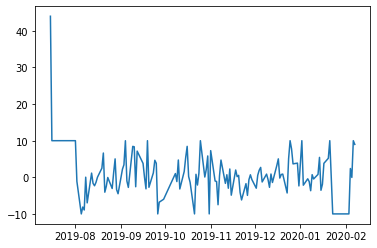

In [95]:
stock_zdm.plot_curve(plot_type='return_ratio')

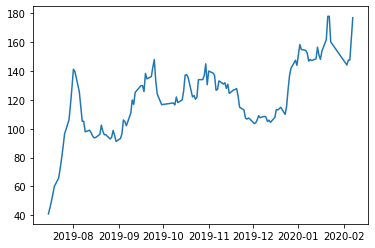

In [96]:
stock_zdm.plot_curve(plot_type='close_price')

In [97]:
stock_zdm.get_statistics()

区间开盘价：34.1
区间最高价：178.03
区间最低价：40.92
区间收盘价：176.97
区间最高收益率：4.220821114369501
区间最低收益率：0.19999999999999996
区间收益率：4.189736070381231


(34.1,
 178.03,
 40.92,
 176.97,
 4.220821114369501,
 0.19999999999999996,
 4.189736070381231)

## 创业板指数的数据

In [98]:
stock_cyb = Stock(code='sz.399006',start_date='2019-07-15',end_date='2020-02-07')

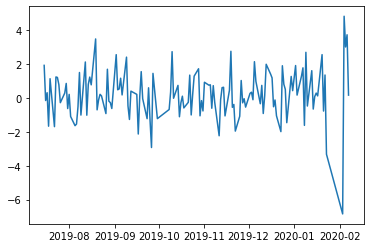

In [99]:
stock_cyb.plot_curve(plot_type='return_ratio')

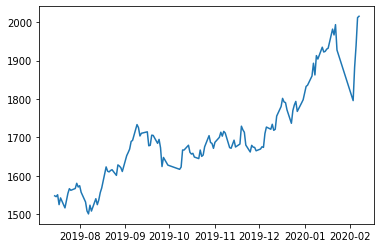

In [100]:
stock_cyb.plot_curve(plot_type='close_price')

In [101]:
stock_cyb.get_statistics()

区间开盘价：1512.767
区间最高价：2015.799
区间最低价：1500.251
区间收盘价：2015.799
区间最高收益率：0.3325244403136769
区间最低收益率：-0.00827358079598517
区间收益率：0.3325244403136769


(1512.767,
 2015.799,
 1500.251,
 2015.799,
 0.3325244403136769,
 -0.00827358079598517,
 0.3325244403136769)

## 信维通信的数据

In [102]:
stock_xw = Stock(code='sz.300136',start_date='2019-07-15',end_date='2020-02-07')

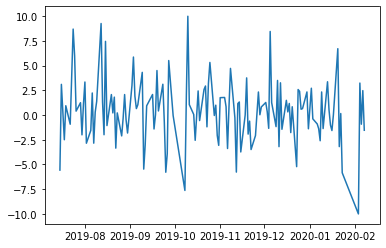

In [103]:
stock_xw.plot_curve(plot_type='return_ratio')

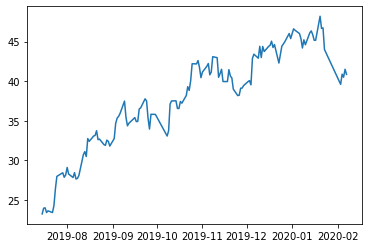

In [104]:
stock_xw.plot_curve(plot_type='close_price')

In [105]:
stock_xw.get_statistics()

区间开盘价：23.01
区间最高价：48.2
区间最低价：23.23
区间收盘价：40.86
区间最高收益率：1.0947414167753151
区间最低收益率：0.009561060408517896
区间收益率：0.7757496740547587


(23.01,
 48.2,
 23.23,
 40.86,
 1.0947414167753151,
 0.009561060408517896,
 0.7757496740547587)

## 波动率与收益率的关系分析

- 波动率：以个股与创业板的协方差来衡量
- 收益率：以个股与创业板的收益差来衡量

In [119]:
# 获取个股和创业板的协方差与超额收益
def get_var(code='sz.300136',start_date='2019-07-15',end_date='2020-02-07'):

    # 获取个股数据
    indiv_stock = Stock(code = code,start_date = start_date,end_date = end_date)
    indiv_info = indiv_stock.get_stock_info()
    # 获取创业板数据
    stock_cyb = Stock(code ='sz.399006',start_date = start_date,end_date = end_date)
    cyb_info = stock_cyb.get_stock_info()

    # 获取个股和创业板的协方差
    indiv_return = indiv_info['pctChg']
    cyb_return = cyb_info['pctChg']
    cov = np.cov([indiv_return,cyb_return])[0][1]

    # 获取个股和创业板的收益率之差
    _,_,_,_,_,_,indiv_return_ratio = indiv_stock.get_statistics(print_info=False)
    _,_,_,_,_,_,cyb_return_ratio = stock_cyb.get_statistics(print_info=False) 
    extra_return_ratio = indiv_return_ratio - cyb_return_ratio
    
    return cov,extra_return_ratio

In [120]:
cov,extra_return_ratio =  get_var()

In [121]:
cov,extra_return_ratio

(2.7475606653193707, 0.4432252337410818)

##  获取指定日期所有股票数据

In [123]:
date = '2020-02-07'
stock_rs = bs.query_all_stock(date)
stock_df = stock_rs.get_data()

In [130]:
# 创业板数据
cyb_stock_list = stock_df[stock_df['code'].apply(lambda x:x.startswith('sz.300'))]

## 分析所有创业板股票的收益率与波动率

分析最近6个月（2019-08-07开始）的股票收益率和波动率：需要这些股票的上市时间都在9个月之前，避免新股上市股价异常波动对分析的影响


#### 1.普通方式计算每个股票的波动率和收益率

In [169]:
var_ls = []

# 过滤掉在2019-05-06之后上市的股票
dt = '2019-05-06'
for i in tqdm(range(len(cyb_stock_list))):
    try:
        # 判断是否上市交易
        code = cyb_stock_list['code'].iloc[i]
        code_name = cyb_stock_list['code_name'].iloc[i]
        stock = Stock(code=code,start_date=dt,end_date=dt)
        if len(stock.get_stock_info())!=0:
            cov,extra_return_ratio =  get_var(code=code,start_date='2019-08-07',end_date='2020-02-07')
            var_ls.append([code,code_name,cov,extra_return_ratio])
    except Exception as e:
        print(i,e)

df_var = pd.DataFrame(var_ls)

df_var.columns = ['code','code_name','var','extra_return']

In [209]:
var_cyb = np.var(stock_cyb.get_stock_info()['pctChg'])

df_var['beta'] = df_var['var'].apply(lambda x:x/var_cyb)

In [217]:
df_var.describe()

,var,extra_return,beta
count,751.000000,751.000000,751.000000
mean,2.102158,-0.128622,0.986196
std,0.606547,0.416891,0.284553
min,-0.205586,-0.823454,-0.096447
25%,1.722363,-0.405101,0.808021
50%,2.052959,-0.220330,0.963116
75%,2.484759,0.039732,1.165688
max,4.163776,4.337972,1.953375


In [224]:
# 按照beta倒序排列
df_var.sort_values(by='beta',ascending=False).head(10)

,code,code_name,var,extra_return,beta
493,sz.300502,新易盛,4.163776,0.930596,1.953375
305,sz.300311,任子行,3.824689,0.046492,1.794297
450,sz.300459,金科文化,3.812332,0.514660,1.788500
111,sz.300115,长盈精密,3.786608,0.580892,1.776432
242,sz.300248,新开普,3.712090,0.315208,1.741473
424,sz.300433,蓝思科技,3.676387,1.175623,1.724723
487,sz.300496,中科创达,3.627890,0.542479,1.701972
374,sz.300383,光环新网,3.496095,0.042941,1.640142
346,sz.300352,北信源,3.473866,0.226956,1.629713
340,sz.300346,南大光电,3.468775,0.869692,1.627325


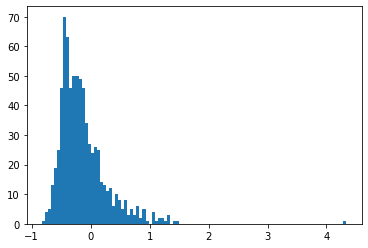

In [219]:
# 超额收益率分布
n,bins,patches = plt.hist(df_var['extra_return'],bins=100)

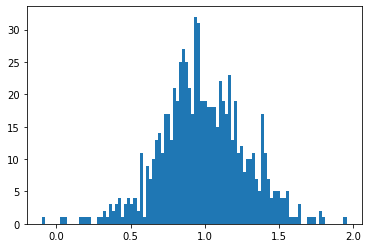

In [221]:
# beta系数的分布
n,bins,patches = plt.hist(df_var['beta'],bins=100)

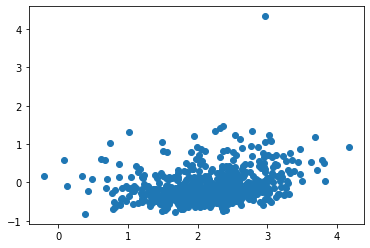

In [196]:
# 协方差与超额收益率的关系
plt.plot(df_var['var'],df_var['extra_return'],'o')

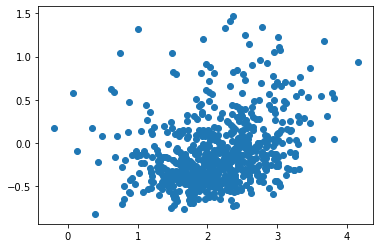

In [216]:
# 过滤掉超额收益率异常高的股票
df_filter = df_var[df_var['extra_return']<4]

plt.plot(df_filter['var'],df_filter['extra_return'],'o')

结论：在2019-08-07到2020-02-07内，创业板股票的波动率与超额收益率并无明显关系